# Coursera Courses Data Visualization Project

In this notebook, we will use data visualizations to explore the features of Coursera courses data and to test if there are meaningful relationships between the variables found in the dataset.

In [720]:
import pandas as pd
import numpy as np
import Levenshtein
import seaborn as sns
import matplotlib.pyplot as plt
import data_cleaning as clean
import warnings

warnings.filterwarnings(
    "ignore", category=UserWarning, 
    message=".*The figure layout has changed to tight.*"
)

pd.options.display.float_format = "{:.1f}".format

In [721]:
data_path = "/Volumes/ADATA_HD710/MacBook/Turing/Sprint_3/materials/coursera_data.csv"
coursera_data = pd.read_csv(data_path, index_col=0).sort_index()
coursera_data.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,IBM Data Science,IBM,PROFESSIONAL CERTIFICATE,4.6,Beginner,480k
1,Introduction to Data Science,IBM,SPECIALIZATION,4.6,Beginner,310k
2,The Science of Well-Being,Yale University,COURSE,4.9,Mixed,2.5m
3,Python for Everybody,University of Michigan,SPECIALIZATION,4.8,Beginner,1.5m
4,Google IT Support,Google,PROFESSIONAL CERTIFICATE,4.8,Beginner,350k


# 1. Data Cleaning

## 1.1 Checking for missing values

In [722]:
clean.print_function(
    "Missing values per column", 
    coursera_data.isnull().sum(), 
    newline=True
)

- Missing values per column:

 course_title                0
course_organization         0
course_Certificate_type     0
course_rating               0
course_difficulty           0
course_students_enrolled    0


## 1.2 Checking for duplicates and similar strings

In this part we will both check if there are repeated fields and also if there are two string values too similar that they might be referring to the same.

In [723]:
clean.check_and_remove_duplicates(coursera_data)

- There are no duplicates


In [724]:
def find_similar_strings(df: pd.DataFrame, column: str, threshold: int) -> list:
    """
    Find pairs of strings in a DataFrame column that are similar 
    by a certain number of characters but not identical.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        column (str): Name of the column to check.
        threshold (int): Maximum number of character 
        differences allowed for strings to be considered similar.

    Returns:
        list: List of tuples with similar string pairs.
    """
    similar_pairs = []
    strings = df[column].dropna().unique()
    n = len(strings)
    for i in range(n):
        for j in range(i + 1, n):
            distance = Levenshtein.distance(strings[i], strings[j])
            if 0 < distance <= threshold:
                similar_pairs.append((strings[i], strings[j], distance))
    return similar_pairs


threshold = 2

In [725]:
find_similar_strings(coursera_data, "course_organization", threshold)
find_similar_strings(coursera_data, "course_title", threshold)

[('TESOL Certificate, Part 1: Teach English Now!',
  'TESOL Certificate, Part 2: Teach English Now!',
  1),
 ('Excel Skills for Business: Intermediate I',
  'Excel Skills for Business: Intermediate II',
  1),
 ('The Power of Macroeconomics: Economic Principles in the Real World',
  'The Power of Microeconomics: Economic Principles in the Real World',
  1)]

We don't see any two values too similar that they might be the same.

## 1.3 Standardizing data types

In [726]:
clean.print_function("Data Types by column", coursera_data.dtypes, newline=True)

- Data Types by column:

 course_title                 object
course_organization          object
course_Certificate_type      object
course_rating               float64
course_difficulty            object
course_students_enrolled     object


We will convert the string column "course_students_enrolled" to a numeric column and change the certificate type values to a title format.

In [727]:
def str_to_int(x: str) -> int:
    """
    Convert a string representation of numbers 
    with 'k' or 'm' suffixes to an integer.

    Args:
        x (str): The string to be converted. 
        It may contain 'k' for thousands or 'm' for millions.

    Returns:
        int: The integer representation of the input string.
    """
    x = str(x)

    if "k" in x:
        return int(float(x.replace("k", "")) * 1000)

    if "m" in x:
        return int(float(x.replace("m", "")) * 1000000)

    else:
        return int(x)

In [728]:
coursera_data["course_students_enrolled"] = coursera_data[
    "course_students_enrolled"
].apply(str_to_int)

In [729]:
coursera_data["course_Certificate_type"] = coursera_data[
    "course_Certificate_type"
].str.title()

Additionally, we will codify difficulty values and certificate types to numerical categories for further analyses.

In [730]:
certificate_codes = {"Course": 0, "Specialization": 1, "Professional Certificate": 2}

difficulty_codes = {"Mixed": 0, "Beginner": 1, "Intermediate": 2, "Advanced": 3}

coursera_data["course_Certificate_num"] = coursera_data["course_Certificate_type"].map(
    certificate_codes
)
coursera_data["course_difficulty_num"] = coursera_data["course_difficulty"].map(
    difficulty_codes
)

In [731]:
coursera_data.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_Certificate_num,course_difficulty_num
0,IBM Data Science,IBM,Professional Certificate,4.6,Beginner,480000,2,1
1,Introduction to Data Science,IBM,Specialization,4.6,Beginner,310000,1,1
2,The Science of Well-Being,Yale University,Course,4.9,Mixed,2500000,0,0
3,Python for Everybody,University of Michigan,Specialization,4.8,Beginner,1500000,1,1
4,Google IT Support,Google,Professional Certificate,4.8,Beginner,350000,2,1


# 2. Exploratory Data Analysis

## 2.1. Analysis of each columns' distribution and basic characteristics

In this section, we will examine the general trends of each of the dataset's features to get a better idea of how it is composed. This way, we will be able to find relationships between variables in a further section.

### 2.1.1. How many courses and course organizations are there?

In [732]:
clean.print_function(
    "Number of organizations", coursera_data["course_organization"].unique().size
)
clean.print_function("Number of courses", coursera_data.shape[0])

- Number of organizations: 154
- Number of courses: 891


### 2.1.3. What organizations hold the greatest number of courses on Coursera?

In [733]:
clean.print_function(
    "Top 10 organizations with highest number of courses",
    coursera_data["course_organization"].value_counts().head(10),
    newline=True,
)

- Top 10 organizations with highest number of courses:

 University of Pennsylvania                    59
University of Michigan                        41
Google Cloud                                  34
Duke University                               28
Johns Hopkins University                      28
University of California, Irvine              27
IBM                                           22
University of Illinois at Urbana-Champaign    22
University of California, Davis               21
University of Virginia                        19


### 2.1.4. Distribution of the number of courses per organization 

In [734]:
clean.print_function(
    "Summary statistics of the number of courses by organization distribution",
    coursera_data["course_organization"].value_counts().describe(),
    newline=True,
)

- Summary statistics of the number of courses by organization distribution:

 count   154.0
mean      5.8
std       8.0
min       1.0
25%       1.0
50%       3.0
75%       6.8
max      59.0


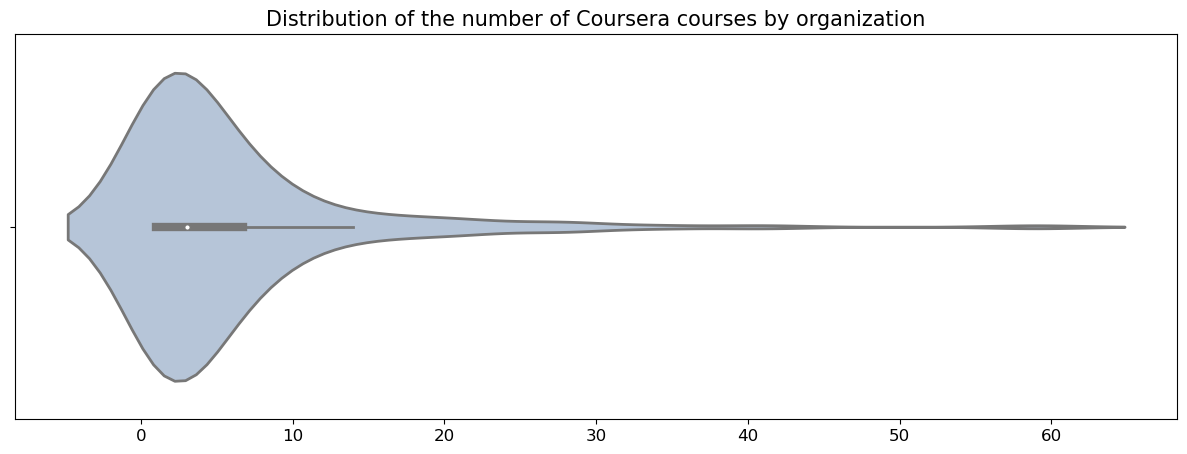

In [735]:
plt.figure(figsize=(15, 5))

sns.violinplot(
    x=coursera_data["course_organization"].value_counts(),
    color="lightsteelblue",
    linewidth=2,
    linecolor="midnightblue",
)

plt.title("Distribution of the number of Coursera courses by organization", 
          fontsize=15)

plt.xlabel("")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

The distribution of the number of Coursera courses per organization is highly skewed to the right, mostly ranging between 1 and 15 courses. There are, however, a handful of organizations which hold a much higher number of courses, such as the University of Pennsilvania with 59 courses.   

### 2.1.5. Number of courses by difficulty and type

In [736]:
clean.print_function(
    "Number of courses by certificate type",
    coursera_data["course_Certificate_type"].value_counts(),
    newline=True,
)

- Number of courses by certificate type:

 Course                      582
Specialization              297
Professional Certificate     12


In [737]:
clean.print_function(
    "Number of courses by difficulty",
    coursera_data["course_difficulty"].value_counts(),
    newline=True,
)

- Number of courses by difficulty:

 Beginner        487
Intermediate    198
Mixed           187
Advanced         19


### 2.1.6. Distribution of course ratings

In [738]:
clean.print_function(
    "Summary statistics of the number of courses by organization distribution",
    coursera_data["course_rating"].describe(),
    newline=True,
)

- Summary statistics of the number of courses by organization distribution:

 count   891.0
mean      4.7
std       0.2
min       3.3
25%       4.6
50%       4.7
75%       4.8
max       5.0


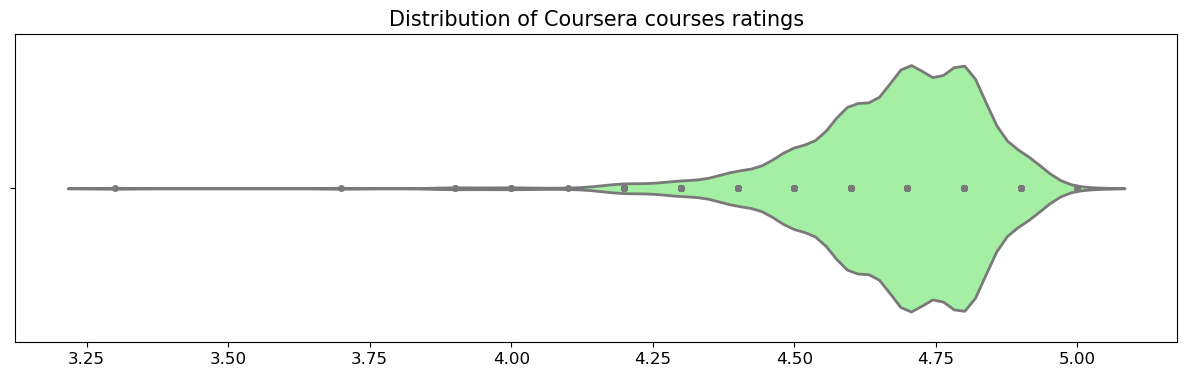

In [739]:
plt.figure(figsize=(15, 4))

sns.violinplot(
    coursera_data,
    x="course_rating",
    inner="point",
    color="palegreen",
    linewidth=2,
    linecolor="black",
)

plt.title("Distribution of Coursera courses ratings", fontsize=15)
plt.xlabel("")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### 2.1.7 Distribution of the number of students enrolled to courses

In [740]:
clean.print_function(
    "Summary statistics of the number of students enrolled to courses",
    coursera_data["course_students_enrolled"].describe(),
    newline=True,
)

- Summary statistics of the number of students enrolled to courses:

 count       891.0
mean      90552.1
std      181936.5
min        1500.0
25%       17500.0
50%       42000.0
75%       99500.0
max     3200000.0


In [741]:
def create_enrollment_plots(
    data: pd.DataFrame, x: str, color: str, x_axis_title: str, suptitle: str
) -> None:
    """
    Creates a box plot and histogram of course enrollments 
    with customizable parameters.

    Parameters:
        data (pd.DataFrame): The input data for the plots.
        x (str): The column name for the x-axis values.
        color (str): The color for the plots.
        x_axis_title (str): The title for the x-axis.
        suptitle (str): The overall title for the figure.
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    sns.boxplot(ax=axes[0], data=data, x=x, color=color)

    sns.histplot(ax=axes[1], data=data, x=x, stat="proportion", 
                 kde=True, color=color)

    axes[1].set_ylabel("Proportion", fontsize=14, labelpad=15)

    axes[1].set_xlabel(x_axis_title, fontsize=14, labelpad=15)

    axes[0].set_xlabel("")

    axes[0].tick_params(axis="both", which="major", labelsize=12)
    axes[1].tick_params(axis="both", which="major", labelsize=12)

    min_value = data[x].min()
    max_value = data[x].max()
    ticks = np.linspace(min_value, max_value, num=10)

    axes[0].set_xticks(ticks)
    axes[1].set_xticks(ticks)

    plt.suptitle(suptitle, fontsize=18)

    plt.tight_layout(rect=[0, 0, 1, 0.98])

    plt.show()

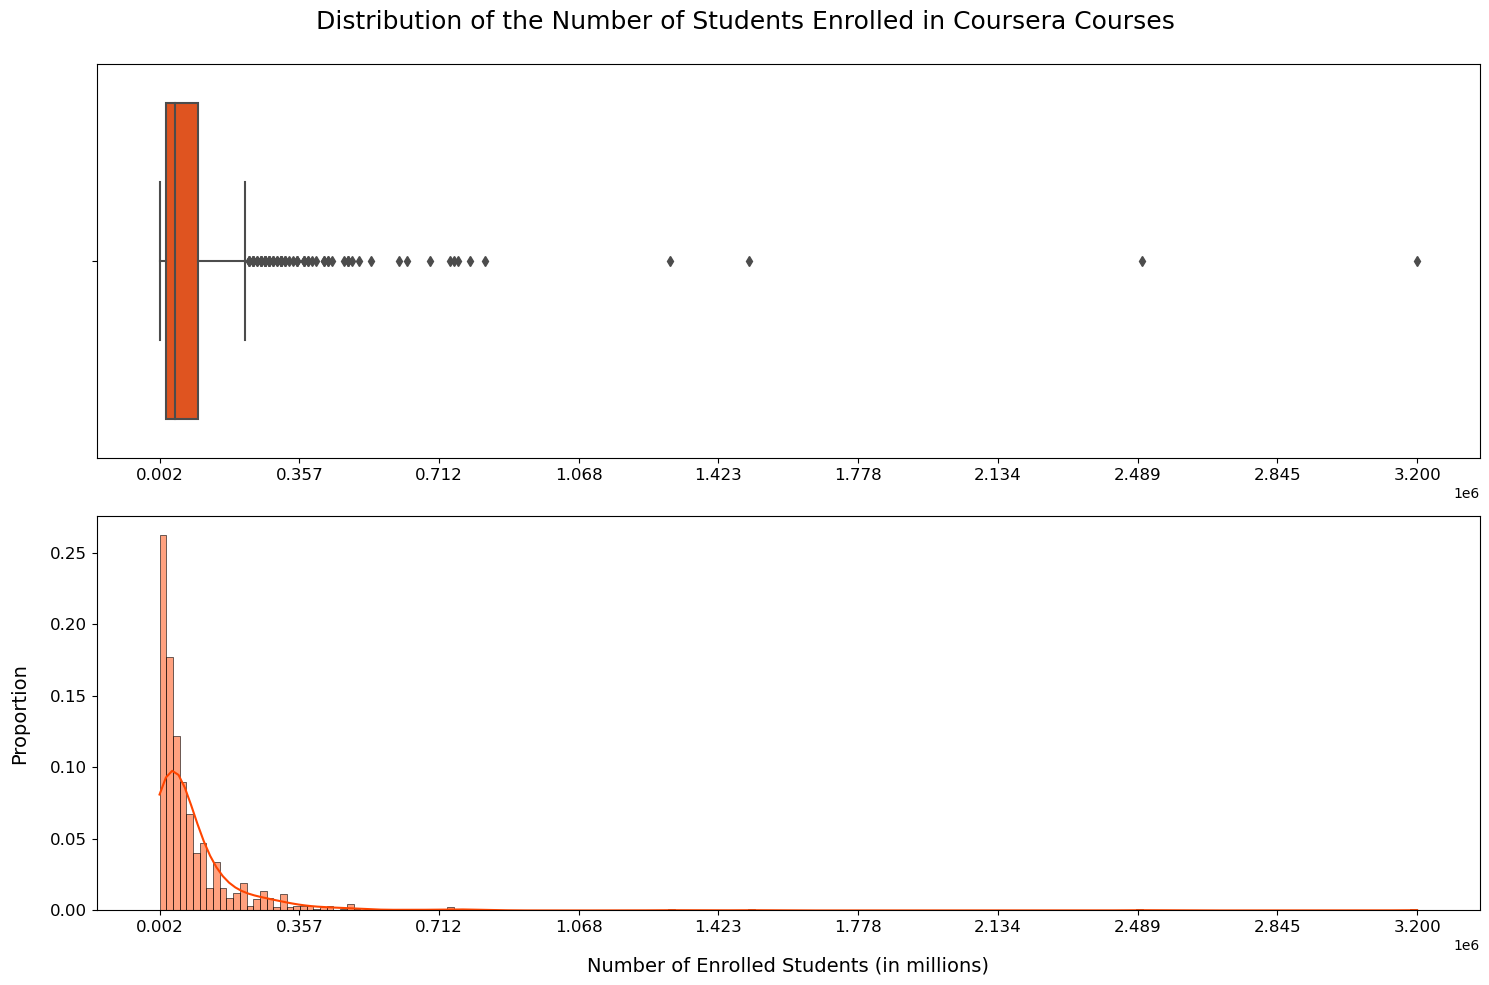

In [742]:
create_enrollment_plots(
    coursera_data,
    "course_students_enrolled",
    "orangered",
    "Number of Enrolled Students (in millions)",
    "Distribution of the Number of Students Enrolled in Coursera Courses",
)

As we can see, the distribution of enrolled students is highly skewed to the right. There are a few courses that are substantially greater in their enrollment numbers than most. We will exclude the outliers in order to see how the distribution changes without this skewness. 

In [743]:
coursera_data["log_course_students_enrolled"] = np.log(
    coursera_data["course_students_enrolled"]
)

In [744]:
high_outliers = clean.detect_outliers(
    coursera_data, "course_students_enrolled", "higher"
)
low_outliers = clean.detect_outliers(coursera_data, 
                                     "course_students_enrolled", "lower")

In [745]:
no_outliers = coursera_data.loc[~coursera_data.index.isin(high_outliers.index)]

In [746]:
coursera_data["is_high_outlier"] = 0
coursera_data.loc[high_outliers.index, "is_high_outlier"] = 1

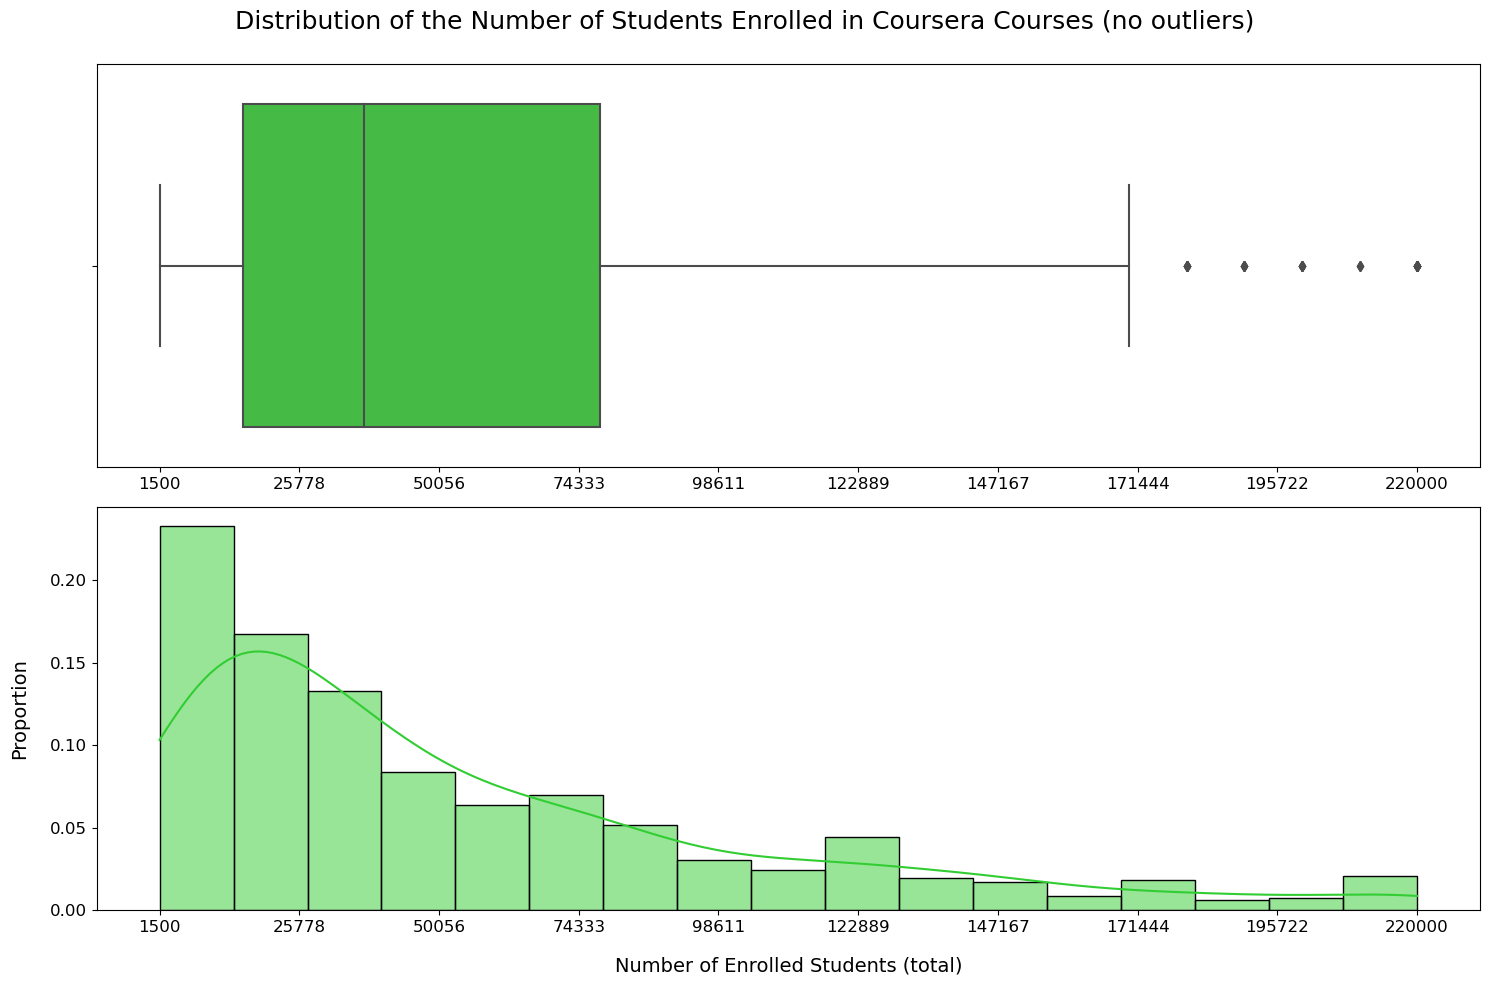

In [747]:
create_enrollment_plots(
    no_outliers,
    "course_students_enrolled",
    "limegreen",
    "Number of Enrolled Students (total)",
    "Distribution of the Number of Students Enrolled in Coursera Courses (no outliers)",
)

As we can see, even though there are less extreme values compared to most observations, the distribution is still clearly skewed to the right. This suggests that the distribution of enrolled students of each course is arguably of a scale free type. Now let's see if this is the same case only for outliers.

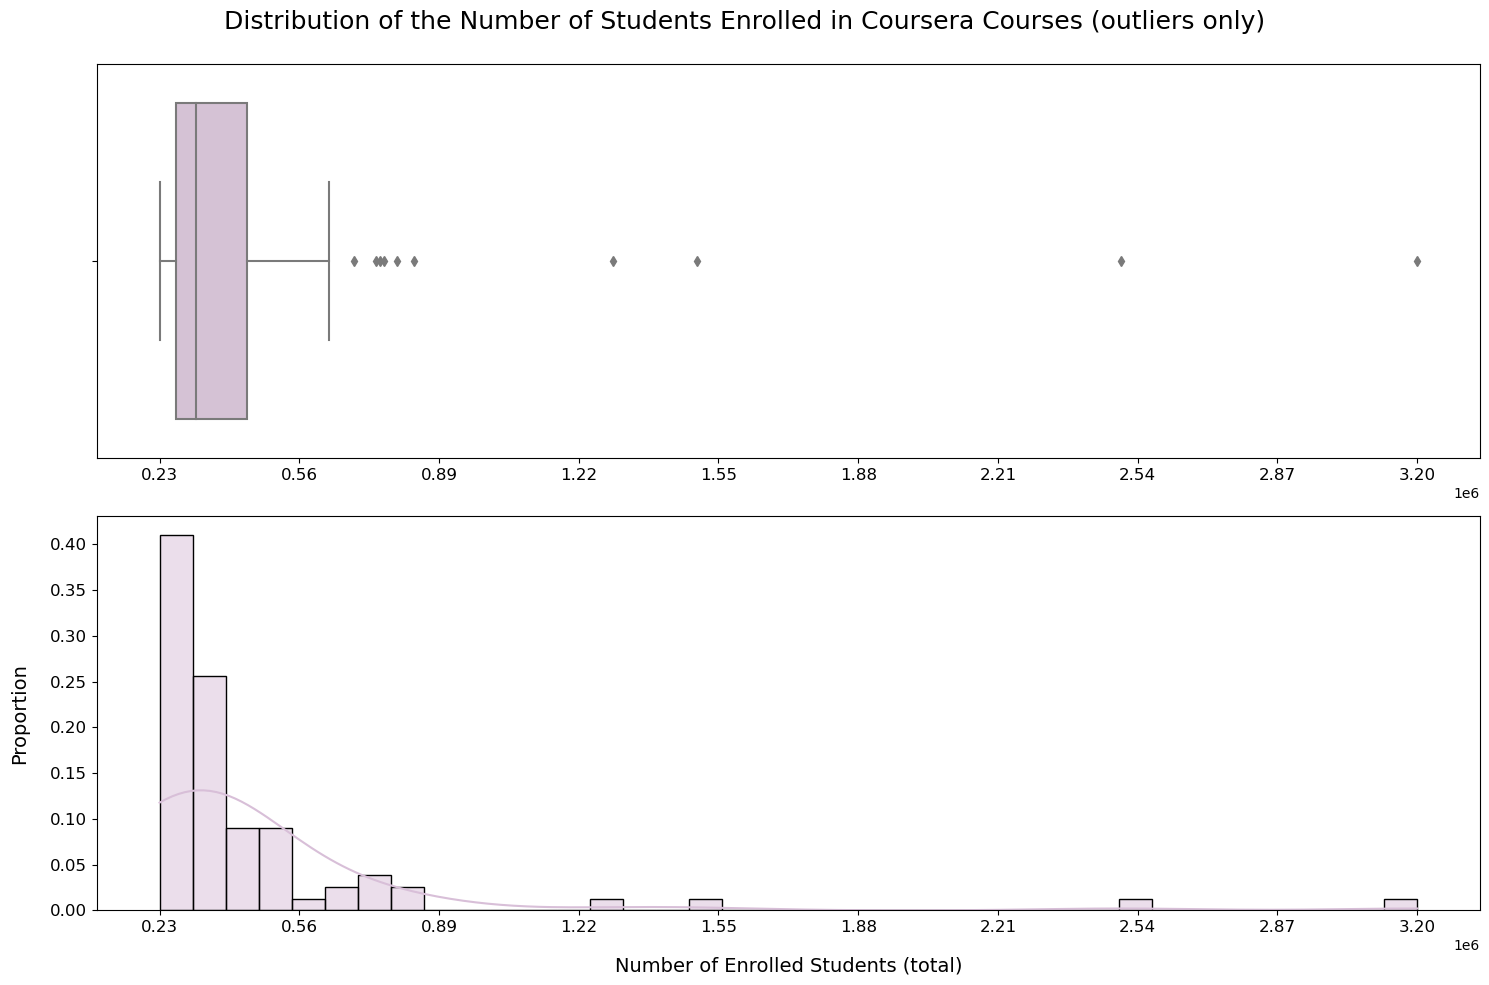

In [748]:
create_enrollment_plots(
    high_outliers,
    "course_students_enrolled",
    "thistle",
    "Number of Enrolled Students (total)",
    "Distribution of the Number of Students Enrolled in Coursera Courses (outliers only)",
)

In [749]:
clean.print_function(
    "Summary statistics of the number of enrolled students (outliers only)",
    high_outliers.course_students_enrolled.describe(),
    newline=True,
)

- Summary statistics of the number of enrolled students (outliers only):

 count        78.0
mean     459615.4
std      450778.4
min      230000.0
25%      270000.0
50%      315000.0
75%      437500.0
max     3200000.0


In a similar vein as the other two datasets, the outliers' distribution also shows that there is a higher concentration in the lower values while the distances between observations widens as we move on to the highest values. This is pointing out that the number of students enrolled by course is a highly unequal distribution where differences between enrollment between courses grow as we reach higher values. 

To see how this inequality behaves, a Lorenz curve can tell us more.

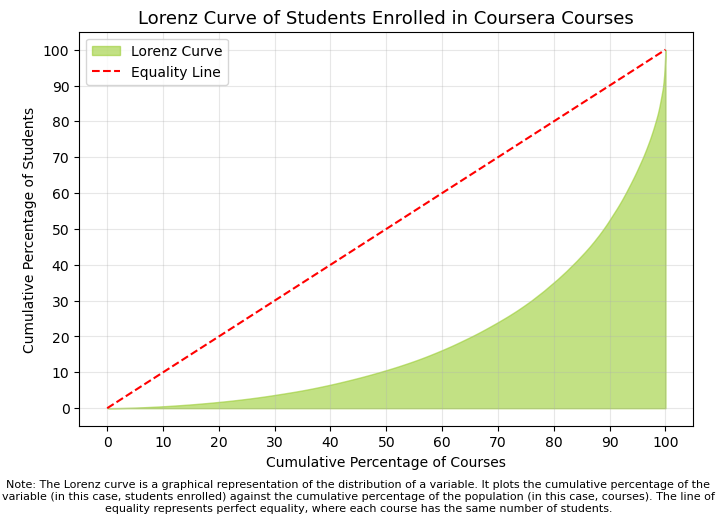

In [750]:
sorted_data = coursera_data.sort_values(by="course_students_enrolled")

sorted_data["cumulative_students"] = sorted_data["course_students_enrolled"].cumsum()
sorted_data["cumulative_percentage_students"] = (
    sorted_data["cumulative_students"]
    / sorted_data["course_students_enrolled"].sum()
    * 100
)

sorted_data["cumulative_percentage_courses"] = (
    np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
)

plt.figure(figsize=(7, 5))
plt.fill_between(
    sorted_data["cumulative_percentage_courses"],
    0,
    sorted_data["cumulative_percentage_students"],
    color="yellowgreen",
    alpha=0.6,
    label="Lorenz Curve",
)
plt.plot([0, 100], [0, 100], linestyle="--", color="r", label="Equality Line")

plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 101, 10))

plt.title("Lorenz Curve of Students Enrolled in Coursera Courses", fontsize="13")
plt.xlabel("Cumulative Percentage of Courses")
plt.ylabel("Cumulative Percentage of Students")
plt.legend()
plt.grid(True, alpha=0.3)

caption_text = (
    "Note: The Lorenz curve is a graphical representation of the distribution of a variable. "
    "It plots the cumulative percentage of the variable (in this case, students enrolled) "
    "against the cumulative percentage of the population (in this case, courses). "
    "The line of equality represents perfect equality, where each course has the same number of students."
)

plt.figtext(
    0.5, -0.05, caption_text, wrap=True, horizontalalignment="center", fontsize=8
)

plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.show()

As we can see with this Lorenz curve, the 10% of courses with the highest number of enrolled students concentrate nearly 50% of all enrolled students in courses, with the other 90% holding the other half. This inequality grows as we move on the higher percentiles. As we can see, the 5% with the highest number of students have a share of nearly 30% of all enrolled students.

Below we can see which are the top 10 courses with the highest enrollments.

In [751]:
super_high_outliers = detect_outliers(
    high_outliers, "course_students_enrolled", "higher"
)
super_high_outliers_sorted = super_high_outliers.sort_values(
    by="course_students_enrolled", ascending=False
)
super_high_outliers_sorted

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_Certificate_num,course_difficulty_num,log_course_students_enrolled
6,Machine Learning,Stanford University,Course,4.9,Mixed,3200000,0,0,15.0
2,The Science of Well-Being,Yale University,Course,4.9,Mixed,2500000,0,0,14.7
3,Python for Everybody,University of Michigan,Specialization,4.8,Beginner,1500000,1,1,14.2
47,Programming for Everybody (Getting Started wit...,University of Michigan,Course,4.8,Mixed,1300000,0,0,14.1
13,Data Science,Johns Hopkins University,Specialization,4.5,Beginner,830000,1,1,13.6
44,Career Success,"University of California, Irvine",Specialization,4.4,Beginner,790000,1,1,13.6
175,English for Career Development,University of Pennsylvania,Course,4.8,Mixed,760000,0,0,13.5
40,Successful Negotiation: Essential Strategies a...,University of Michigan,Course,4.8,Mixed,750000,0,0,13.5
15,Data Science: Foundations using R,Johns Hopkins University,Specialization,4.6,Beginner,740000,1,1,13.5
5,Deep Learning,deeplearning.ai,Specialization,4.8,Intermediate,690000,1,2,13.4


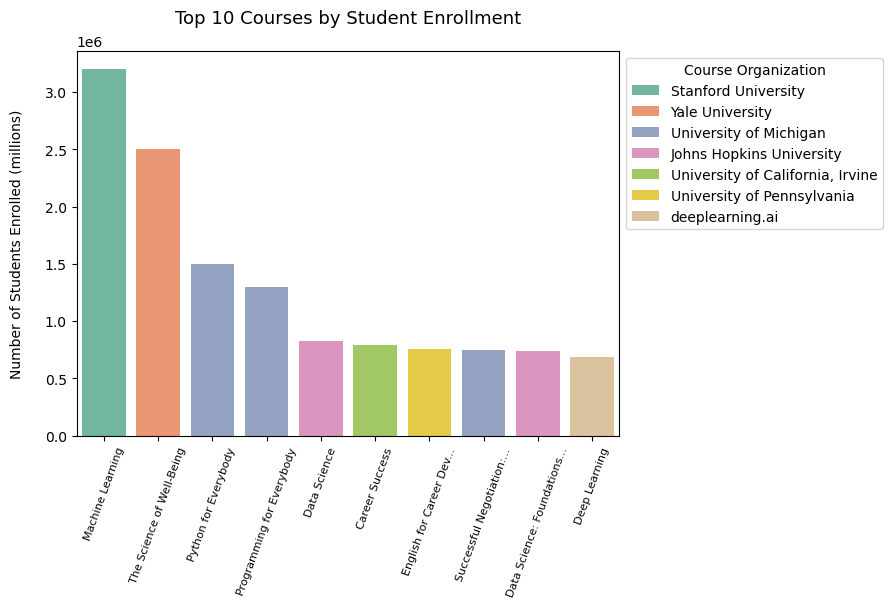

In [752]:
truncated_labels = [
    "Machine Learning",
    "The Science of Well-Being",
    "Python for Everybody",
    "Programming for Everybody",
    "Data Science",
    "Career Success",
    "English for Career Dev...",
    "Successful Negotiation:...",
    "Data Science: Foundations...",
    "Deep Learning",
]

plt.figure(figsize=(7, 5))
barplot = sns.barplot(
    data=super_high_outliers_sorted,
    x="course_title",
    y="course_students_enrolled",
    hue="course_organization",
    dodge=False,
    palette="Set2",
)

plt.title("Top 10 Courses by Student Enrollment", size=12, fontsize=13, y=1.05)

plt.xticks(
    ticks=range(len(truncated_labels)), labels=truncated_labels, rotation=70, size=8
)

plt.legend(title="Course Organization", bbox_to_anchor=(1, 1), loc="upper left")
plt.xlabel("")
plt.ylabel("Number of Students Enrolled (millions)", labelpad=15)

plt.legend(title="Course Organization", bbox_to_anchor=(1, 1), loc="upper left")

plt.show()

## 2.2. Relationships between variables

In this section, we will explore if and how there are signs of relevant associations between the different variables in the Coursera dataset without conducting statistical analysis.

### 2.2.1. Enrollment and course difficulty

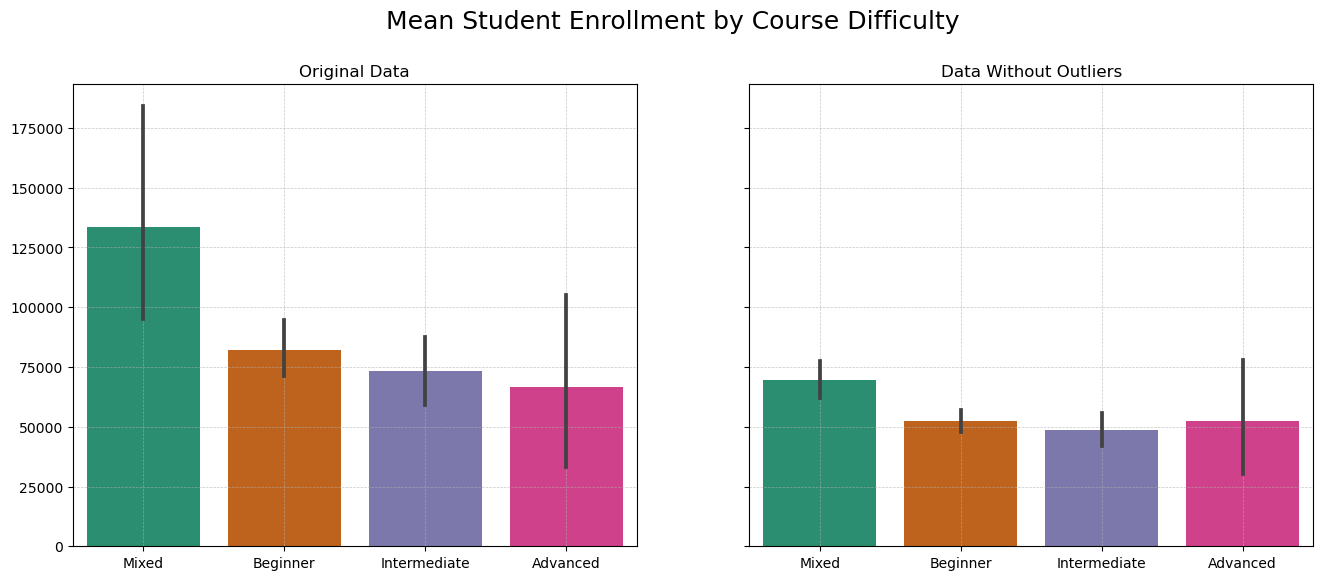

In [753]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.barplot(
    ax=axes[0],
    data=coursera_data,
    x="course_difficulty",
    y="course_students_enrolled",
    order=["Mixed", "Beginner", "Intermediate", "Advanced"],
    errorbar=("ci", 95),
    palette="Dark2",
)
axes[0].set_title("Original Data")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

sns.barplot(
    ax=axes[1],
    data=no_outliers,
    x="course_difficulty",
    y="course_students_enrolled",
    order=["Mixed", "Beginner", "Intermediate", "Advanced"],
    errorbar=("ci", 95),
    palette="Dark2",
)
axes[1].set_title("Data Without Outliers")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.suptitle("Mean Student Enrollment by Course Difficulty", 
             fontsize=18, y=1.005)

for ax in axes:
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

From the plots above, we observe that both with the full dataset and excluding outliers, the courses with mixed difficulty have a higher mean enrollment than the rest of difficulty categories. These results show that mixed difficulty courses are statistically higher than beginner and intermediate courses with confidence intervals at the 95% level. We cannot conclude the same thing for advanced courses as their confidence intervals are much wider -possibly as a result of their low number in our dataset- and they intertwine with the mixed courses confidence intervals.

It must be noted that these means might be driven by some extreme values, so we shall take a closer inspection to the data points to tell if this is the case.

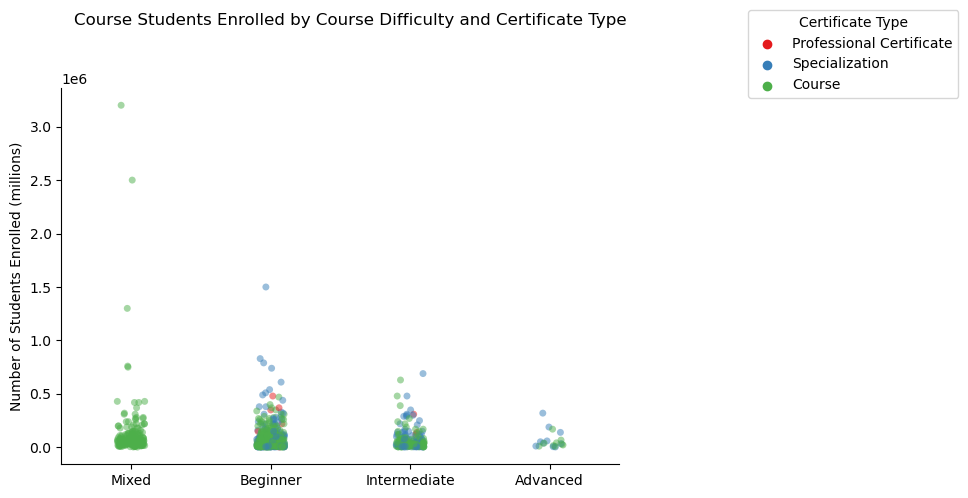

In [754]:
cat_plot = sns.catplot(
    data=coursera_data,
    x="course_difficulty",
    y="course_students_enrolled",
    hue="course_Certificate_type",
    palette="Set1",
    order=["Mixed", "Beginner", "Intermediate", "Advanced"],
    alpha=0.5,
)

cat_plot._legend.remove()

cat_plot.set_axis_labels("", "Number of Students Enrolled (millions)")
cat_plot.fig.suptitle(
    "Course Students Enrolled by Course Difficulty and Certificate Type"
)

cat_plot.fig.legend(
    title="Certificate Type", bbox_to_anchor=(1.05, 1), loc="upper left"
)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.show()

As we can see, data points in the Mixed and Beginner categories have some extreme values that might be driving the means upward. Hence, let us check if this same behavior holds for the dataset without outliers.

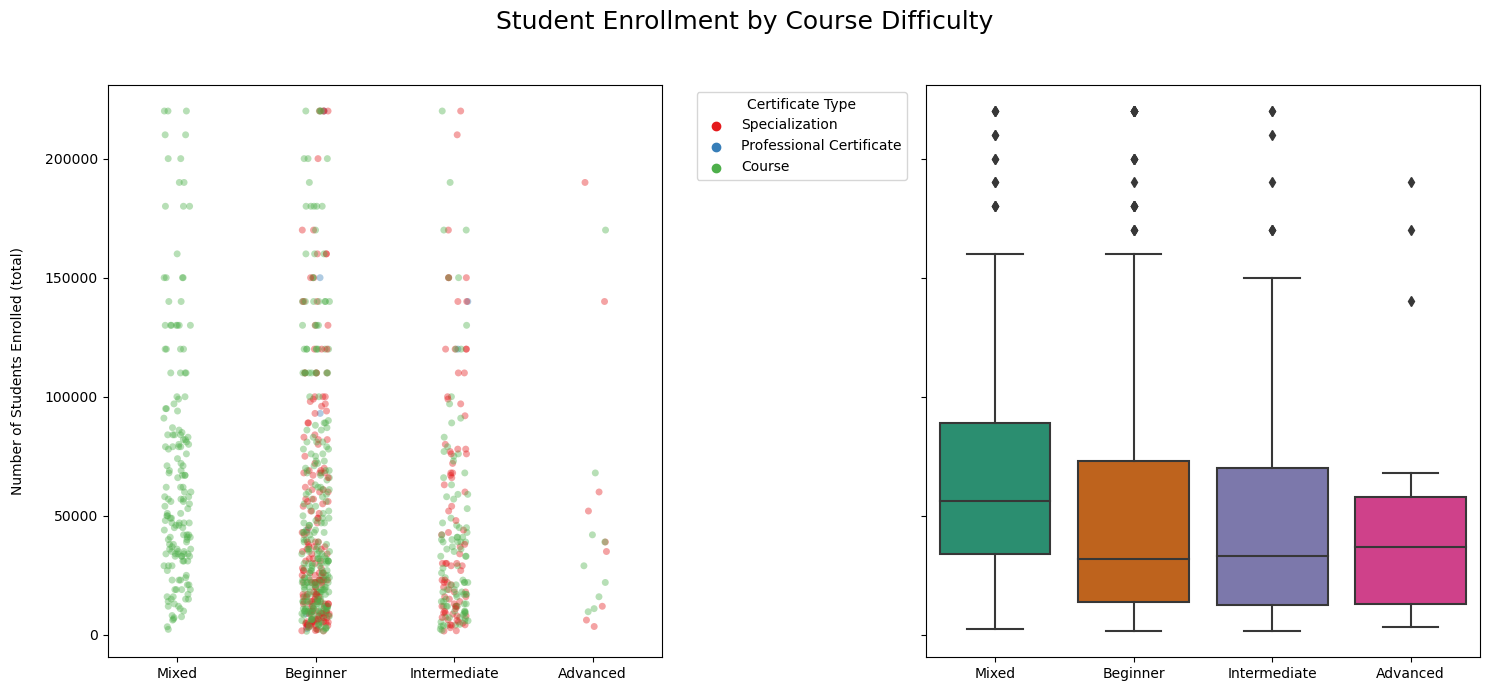

In [755]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

sns.stripplot(
    ax=axes[0],
    data=no_outliers,
    x="course_difficulty",
    y="course_students_enrolled",
    hue="course_Certificate_type",
    order=["Mixed", "Beginner", "Intermediate", "Advanced"],
    alpha=0.4,
    palette="Set1",
)
axes[0].set_xlabel("")
axes[0].set_ylabel("Number of Students Enrolled (total)", labelpad=15)
axes[0].legend(title="Certificate Type", bbox_to_anchor=(1.05, 1), loc="upper left")


sns.boxplot(
    ax=axes[1],
    data=no_outliers,
    x="course_difficulty",
    y="course_students_enrolled",
    order=["Mixed", "Beginner", "Intermediate", "Advanced"],
    palette="Dark2",
)
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.suptitle("Student Enrollment by Course Difficulty", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

As we can see from both plots above, variances are not very different between the Mixed, Beginner and Intermediate difficulties in the dataset without outliers. The three of them have similar ranges and their outliers are situated roughly in the same positions. However, from the boxplot it is also clear that the largest share of values in the Mixed category is higher than in all the other categories. Furthermore, we can also see that the Advanced category has a few outliers that might be driving its mean upwards, while the core of its values are in a much lower part of the distribution. 

With all this information, we can safely conclude that the Mixed difficulty courses have more students enrolled, on average, than the rest of the difficulty categories, even when accounting for outliers. 

For the sake of discussion, we can think that Mixed difficulty courses are more popular because they are flexible enough to let students progress from the base onto higher levels within a single track.

### 2.2.2. Enrollment & certificate types

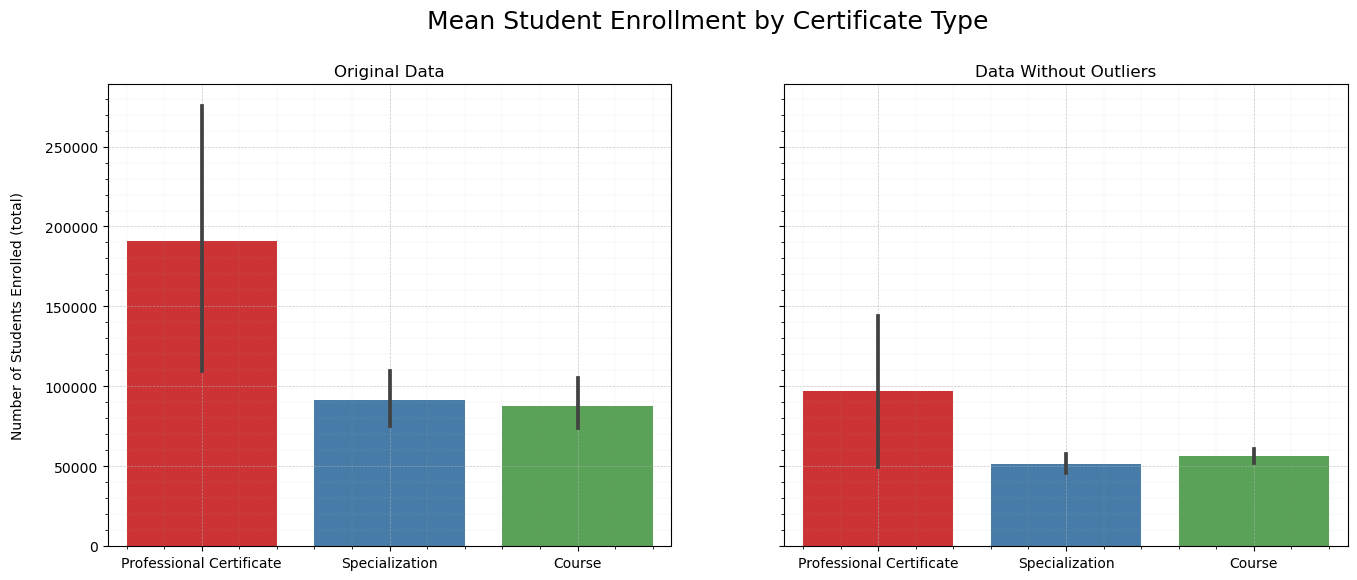

In [756]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.barplot(
    ax=axes[0],
    data=coursera_data,
    x="course_Certificate_type",
    y="course_students_enrolled",
    order=["Professional Certificate", "Specialization", "Course"],
    errorbar=("ci", 95),
    palette="Set1",
)
axes[0].set_title("Original Data")
axes[0].set_xlabel("")
axes[0].set_ylabel("Number of Students Enrolled (total)", labelpad=15)

sns.barplot(
    ax=axes[1],
    data=no_outliers,
    x="course_Certificate_type",
    y="course_students_enrolled",
    order=["Professional Certificate", "Specialization", "Course"],
    errorbar=("ci", 95),
    palette="Set1",
)
axes[1].set_title("Data Without Outliers")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.suptitle("Mean Student Enrollment by Certificate Type", fontsize=18, y=1.005)

for ax in axes:
    ax.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.3, alpha=0.5)
    ax.minorticks_on()

Despite its wide confidence intervals -possibly as a result of having few observations, Professional Certificate courses show a higher mean enrollment than the other type of courses. However, when we exclude outliers, the evidence is not conclusive.

¿Could it be that the outliers are driving the mean enrollment of the Professional Certificate courses up?

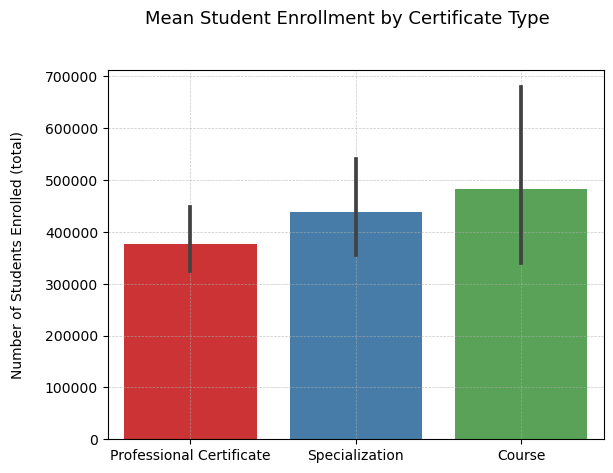

In [757]:
sns.barplot(
    data=high_outliers,
    x="course_Certificate_type",
    y="course_students_enrolled",
    order=["Professional Certificate", "Specialization", "Course"],
    errorbar=("ci", 95),
    palette="Set1",
)
plt.ylabel("Number of Students Enrolled (total)", labelpad=15)
plt.xlabel("")
plt.suptitle("Mean Student Enrollment by Certificate Type", fontsize=13, y=1.005)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

From the plot below, we actually see that there is no statistical difference between the three certificate types. In that sense, it could be the case that professional certificates are more popular, on average, than the rest of certificate types. However, a closer statistical analysis has to be conducted to safely support this. What we can say, in any case, is that there is no significant difference between regular courses and sepcialization courses in terms of their level of enrollment.

### 2.2.3 Enrollment & ratings 

Ratings and enrollment are numerical variables, so scatter plots are a natural way to plot their relationships. However, as enrollment values have a high dispersion, we will use its logarithmic transformation for better visualization of the plots. 

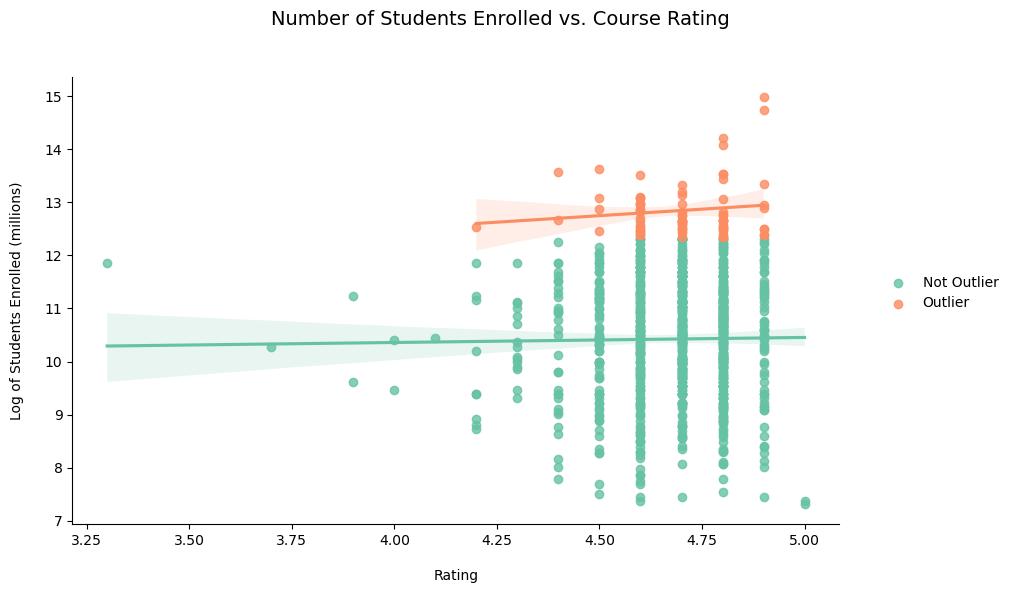

In [758]:
lm_plot = sns.lmplot(
    data=coursera_data,
    x="course_rating",
    y="log_course_students_enrolled",
    hue="is_high_outlier",
    height=6,
    aspect=1.5,
    palette="Set2",
)

lm_plot.set_axis_labels("Rating", "Log of Students Enrolled (millions)", labelpad=15)
lm_plot.fig.suptitle("Number of Students Enrolled vs. Course Rating", size=14)

new_labels = ["Not Outlier", "Outlier"]
for t, l in zip(lm_plot._legend.texts, new_labels):
    t.set_text(l)

lm_plot._legend.set_title("")

lm_plot._legend.set_bbox_to_anchor((1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 0.95])

plt.show()

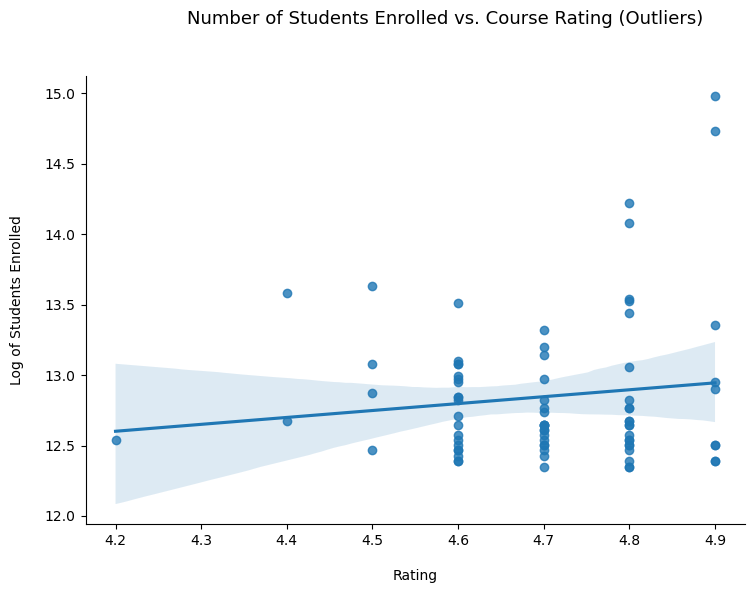

In [759]:
lm_plot_high_outliers = sns.lmplot(
    data=high_outliers,
    x="course_rating",
    y="log_course_students_enrolled",
    height=6,
    aspect=1.5,
    palette="Set1",
)

# Customize the lmplot
lm_plot_high_outliers.set_axis_labels("Rating", "Log of Students Enrolled", labelpad=15)
lm_plot_high_outliers.fig.suptitle(
    "Number of Students Enrolled vs. Course Rating (Outliers)", size=13
)

plt.tight_layout(rect=[0, 0, 0.85, 0.95])

# Show the plot
plt.show()

We observe that there is no clear correlation between ratings and enrollment. For outlier observations, this relationship might be mildly positive, but further statistical analysis is required to conclude if the association is significant.

### 2.2.3 Enrollment & number of courses per organization

Now we will explore if there is any association between the number of courses taught by each organization and their mean enrollment. While we can think that organizations that have more number of courses potentially have a greater number of enrolled students, we do not know if this actually holds. It could be the case that the average number of students enrolled for the multiple courses taught by an organization is low, while the few courses taught by another organization could be very popular. 

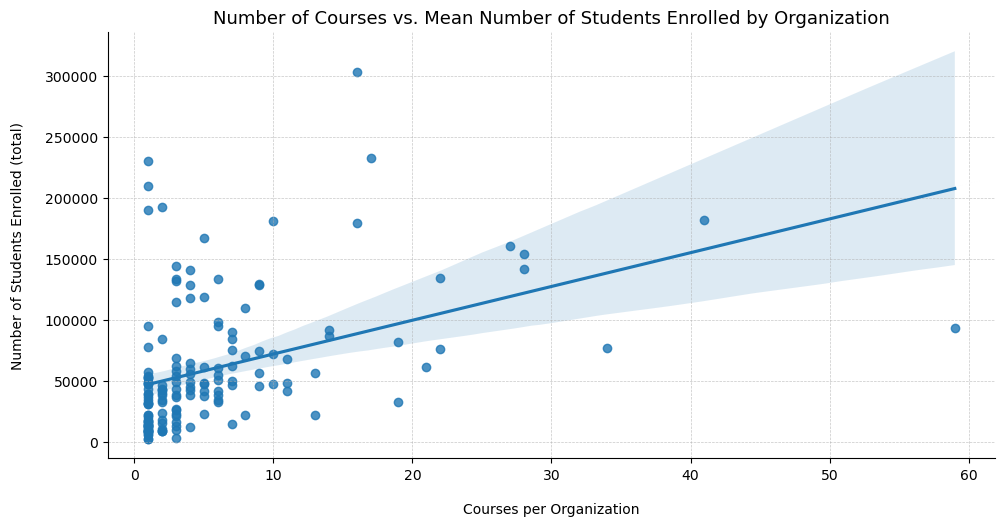

In [760]:
organization_stats = (
    coursera_data.groupby("course_organization")
    .agg(
        number_of_courses=("course_organization", "size"),
        mean_students_enrolled=("course_students_enrolled", "mean"),
    )
    .reset_index()
)

sns.lmplot(
    data=organization_stats,
    x="number_of_courses",
    y="mean_students_enrolled",
    aspect=2,
    palette="plasma",
)

plt.title(
    "Number of Courses vs. Mean Number of Students Enrolled by Organization", size=13
)
plt.xlabel("Courses per Organization", labelpad=15)
plt.ylabel("Number of Students Enrolled (total)", labelpad=15)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.show()

As we can see, there seems to be a positive association between the number of courses taught by organizations and their average number of enrolled students. 

### 2.2.4 Correlations

Finally, let us observe the correlations between numerical variables in the dataset. For these ends, difficulty and certificate types were coded according to their order, from least complex to more complex. In the case of the Mixed difficulty category, it was coded as a 0, as it also includes beginner difficulty.

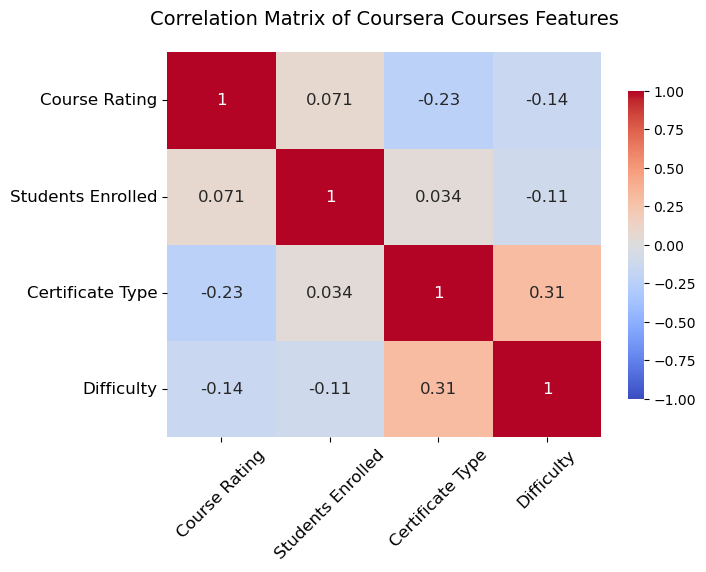

In [761]:
corr_matrix = coursera_data[
    [
        "course_rating",
        "course_students_enrolled",
        "course_Certificate_num",
        "course_difficulty_num",
    ]
].corr()

corr_matrix.columns = [
    "Course Rating",
    "Students Enrolled",
    "Certificate Type",
    "Difficulty",
]
corr_matrix.index = [
    "Course Rating",
    "Students Enrolled",
    "Certificate Type",
    "Difficulty",
]

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    annot_kws={"size": 12},
    cbar_kws={"shrink": 0.8},
)

# Add titles and adjust font sizes
plt.title("Correlation Matrix of Coursera Courses Features", fontsize=14, pad=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)

# Show the plot
plt.show()

From the heatmap above, we do not observe strong correlations in any of the variables. The highest correlation is between difficulty and certificate type, which is positive. This makes sense, as there is a greater chance that Specialization and Professional Certificates have a higher difficulty. 

Secondly, there is a mild negative correlation between certficate types and ratings. There is also a small negative correlation between difficulty and ratings and between difficulty and enrollment. 

Further analysis must be done in order to determine the effect sizes between these variables accounting for their possible confounding factors and statistical significance.

# 3. Further research

Doing a recapitulation of the actions that could enrich this analysis and adding a few more, we conclude the following tasks to undertake:

1. Build regression models with controls to determine the sole effects that variables have on each other.
2. Determine if enrollment distribution is truly scale-free by finding its corresponding parameters.
3. Study more relations between variables, such as organization and levels of difficulty or certificate types.
4. Categorize courses by subject and investigate relations between subject and the rest of the variables.